### Python 3.8.10

In [2]:
!pip install -r requirements.txt
import numpy as np
import torch
from torchvision import transforms, datasets
from torchvision.utils import save_image

import unsplit.attacks as unsplit
from unsplit.models import *
from unsplit.util import *

import optimizers as opt

import scipy



  Using cached torch-1.7.1-cp38-cp38-manylinux1_x86_64.whl (776.8 MB)
ERROR: Could not find a version that satisfies the requirement scipy==1.12.0 (from -r requirements.txt (line 5)) (from versions: 0.8.0, 0.9.0, 0.10.0, 0.10.1, 0.11.0, 0.12.0, 0.12.1, 0.13.0, 0.13.1, 0.13.2, 0.13.3, 0.14.0, 0.14.1, 0.15.0, 0.15.1, 0.16.0, 0.16.1, 0.17.0, 0.17.1, 0.18.0, 0.18.1, 0.19.0, 0.19.1, 1.0.0, 1.0.1, 1.1.0, 1.2.0, 1.2.1, 1.2.2, 1.2.3, 1.3.0, 1.3.1, 1.3.2, 1.3.3, 1.4.0, 1.4.1, 1.5.0, 1.5.1, 1.5.2, 1.5.3, 1.5.4, 1.6.0, 1.6.1, 1.6.2, 1.6.3, 1.7.0, 1.7.1, 1.7.2, 1.7.3, 1.8.0rc1, 1.8.0rc2, 1.8.0rc3, 1.8.0rc4, 1.8.0, 1.8.1, 1.9.0rc1, 1.9.0rc2, 1.9.0rc3, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0rc1, 1.10.0rc2, 1.10.0, 1.10.1)
ERROR: No matching distribution found for scipy==1.12.0 (from -r requirements.txt (line 5))


In [3]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device_count())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

True
0
1


device(type='cuda')

In [3]:
split_layer = 2

In [4]:
dataset = 'mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

In [5]:
for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)

## Learning without noise

In [28]:
client_opt = torch.optim.SGD(client.parameters(), lr=0.001)
server_opt = torch.optim.SGD(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 50
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Epoch: 0 Loss: 2.302849531173706 Acc: 20.394736842105264
Epoch: 1 Loss: 2.3002285957336426 Acc: 16.294277929155314
Epoch: 2 Loss: 2.297558546066284 Acc: 17.40801757276222
Epoch: 3 Loss: 2.2943904399871826 Acc: 18.954248366013072
Epoch: 4 Loss: 2.2903969287872314 Acc: 25.583982202447164
Epoch: 5 Loss: 2.2847559452056885 Acc: 30.925013683634372
Epoch: 6 Loss: 2.2757861614227295 Acc: 33.49726775956284
Epoch: 7 Loss: 2.2591288089752197 Acc: 38.121245221190605
Epoch: 8 Loss: 2.222214460372925 Acc: 43.67816091954023
Epoch: 9 Loss: 2.120591878890991 Acc: 46.44420131291029
Epoch: 10 Loss: 1.7785375118255615 Acc: 69.07103825136612
Epoch: 11 Loss: 1.1191990375518799 Acc: 78.82611080636313
Epoch: 12 Loss: 0.6969941258430481 Acc: 83.04061470911087
Epoch: 13 Loss: 0.5477314591407776 Acc: 86.81440443213296
Epoch: 14 Loss: 0.4752420485019684 Acc: 87.4451754385965
Epoch: 15 Loss: 0.427045613527298 Acc: 88.21271929824562
Epoch: 16 Loss: 0.3906811773777008 Acc: 88.94362342638205
Epoch: 17 Loss: 0.361325

## Learning with noise

In [8]:
import torch.distributions as dist

class CustomNormalDistribution(nn.Module):
    def __init__(self, shape, mean, std):
        super(CustomNormalDistribution, self).__init__()
        self.shape = shape
        self.mean = nn.Parameter(torch.tensor(mean))
        self.std = nn.Parameter(torch.tensor(std))

    def forward(self):
        return dist.Normal(self.mean, self.std)


def noisybatch(images, mean=0.0, std=1.0):
    shape = images.shape
    custom_dist = CustomNormalDistribution(shape, mean, std)
    sample = custom_dist().rsample()
    return sample

Find global $l2$-sensitivity 

Now let us adjust distribution parameter $\sigma$ for $(\varepsilon, \delta)$-DP.

Code is taken from https://github.com/BorjaBalle/analytic-gaussian-mechanism/blob/master/agm-example.py

In [9]:
from math import exp, sqrt
from scipy.special import erf

def calibrateAnalyticGaussianMechanism(epsilon, delta, GS, tol = 1.e-12):
    """ Calibrate a Gaussian perturbation for differential privacy using the analytic Gaussian mechanism of [Balle and Wang, ICML'18]

    Arguments:
    epsilon : target epsilon (epsilon > 0)
    delta : target delta (0 < delta < 1)
    GS : upper bound on L2 global sensitivity (GS >= 0)
    tol : error tolerance for binary search (tol > 0)

    Output:
    sigma : standard deviation of Gaussian noise needed to achieve (epsilon,delta)-DP under global sensitivity GS
    """

    def Phi(t):
        return 0.5*(1.0 + erf(float(t)/sqrt(2.0)))

    def caseA(epsilon,s):
        return Phi(sqrt(epsilon*s)) - exp(epsilon)*Phi(-sqrt(epsilon*(s+2.0)))

    def caseB(epsilon,s):
        return Phi(-sqrt(epsilon*s)) - exp(epsilon)*Phi(-sqrt(epsilon*(s+2.0)))

    def doubling_trick(predicate_stop, s_inf, s_sup):
        while(not predicate_stop(s_sup)):
            s_inf = s_sup
            s_sup = 2.0*s_inf
        return s_inf, s_sup

    def binary_search(predicate_stop, predicate_left, s_inf, s_sup):
        s_mid = s_inf + (s_sup-s_inf)/2.0
        while(not predicate_stop(s_mid)):
            if (predicate_left(s_mid)):
                s_sup = s_mid
            else:
                s_inf = s_mid
            s_mid = s_inf + (s_sup-s_inf)/2.0
        return s_mid

    delta_thr = caseA(epsilon, 0.0)

    if (delta == delta_thr):
        alpha = 1.0

    else:
        if (delta > delta_thr):
            predicate_stop_DT = lambda s : caseA(epsilon, s) >= delta
            function_s_to_delta = lambda s : caseA(epsilon, s)
            predicate_left_BS = lambda s : function_s_to_delta(s) > delta
            function_s_to_alpha = lambda s : sqrt(1.0 + s/2.0) - sqrt(s/2.0)

        else:
            predicate_stop_DT = lambda s : caseB(epsilon, s) <= delta
            function_s_to_delta = lambda s : caseB(epsilon, s)
            predicate_left_BS = lambda s : function_s_to_delta(s) < delta
            function_s_to_alpha = lambda s : sqrt(1.0 + s/2.0) + sqrt(s/2.0)

        predicate_stop_BS = lambda s : abs(function_s_to_delta(s) - delta) <= tol

        s_inf, s_sup = doubling_trick(predicate_stop_DT, 0.0, 1.0)
        s_final = binary_search(predicate_stop_BS, predicate_left_BS, s_inf, s_sup)
        alpha = function_s_to_alpha(s_final)
        
    sigma = alpha*GS/sqrt(2.0*epsilon)

    return sigma

In [10]:
sigma = calibrateAnalyticGaussianMechanism(0.5, 0.5, 1.0)
sigma

0.5909175992591167

In [18]:
client_opt = torch.optim.SGD(client.parameters(), lr=0.001)
server_opt = torch.optim.SGD(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 50
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()
        noise = noisybatch(images, mean=0.0, std=sigma)
        pred = server(client(torch.add(images, noise), end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Epoch: 0 Loss: 2.3043153285980225 Acc: 9.269356597600872
Epoch: 1 Loss: 2.3026556968688965 Acc: 11.703296703296703
Epoch: 2 Loss: 2.3011929988861084 Acc: 10.049696300386527
Epoch: 3 Loss: 2.2998268604278564 Acc: 9.902597402597403
Epoch: 4 Loss: 2.298461437225342 Acc: 11.050027487630567
Epoch: 5 Loss: 2.297058582305908 Acc: 10.76158940397351
Epoch: 6 Loss: 2.295353651046753 Acc: 18.997797356828194
Epoch: 7 Loss: 2.2933592796325684 Acc: 18.763796909492275
Epoch: 8 Loss: 2.2908177375793457 Acc: 17.197802197802197
Epoch: 9 Loss: 2.2876474857330322 Acc: 16.712030484485574
Epoch: 10 Loss: 2.2831954956054688 Acc: 19.15367483296214
Epoch: 11 Loss: 2.2765145301818848 Acc: 32.15664644236073
Epoch: 12 Loss: 2.2662856578826904 Acc: 47.27272727272727
Epoch: 13 Loss: 2.247987985610962 Acc: 58.29694323144105
Epoch: 14 Loss: 2.211324691772461 Acc: 59.651984774333876
Epoch: 15 Loss: 2.1250743865966797 Acc: 59.40594059405941
Epoch: 16 Loss: 1.8649587631225586 Acc: 65.67328918322296
Epoch: 17 Loss: 1.306

Now let us see how adding noise affects on attacks.

In [12]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]

In [15]:
noised_inversion_targets = inversion_targets
inversion_targets[0].shape

for c in range(10): 
    noise = noisybatch(inversion_targets[c], mean=0.0, std=sigma)
    noised_inversion_targets[c] = torch.add(inversion_targets[c], noise)

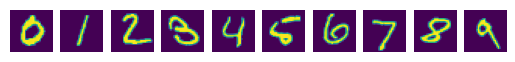

In [17]:
targetloader = torch.utils.data.DataLoader(noised_inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(noised_inversion_targets, 28, 28)

## Split layer = 2

Without noise:

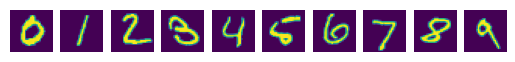

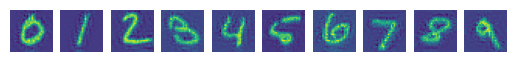

In [31]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

With noise:

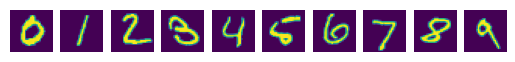

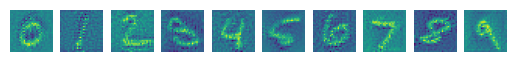

In [19]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

# Split layer = 3

 Without noise

In [20]:
split_layer = 3

dataset = 'mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.SGD(client.parameters(), lr=0.001)
server_opt = torch.optim.SGD(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 50
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Epoch: 0 Loss: 2.301586866378784 Acc: 9.90695128626163
Epoch: 1 Loss: 2.2995126247406006 Acc: 9.833333333333334
Epoch: 2 Loss: 2.297455072402954 Acc: 10.326086956521738
Epoch: 3 Loss: 2.295138120651245 Acc: 14.810751508502468
Epoch: 4 Loss: 2.2923223972320557 Acc: 21.696035242290748
Epoch: 5 Loss: 2.2885243892669678 Acc: 22.84931506849315
Epoch: 6 Loss: 2.2830047607421875 Acc: 30.03865267807841
Epoch: 7 Loss: 2.2741918563842773 Acc: 33.205479452054796
Epoch: 8 Loss: 2.2573423385620117 Acc: 36.013215859030836
Epoch: 9 Loss: 2.220493793487549 Acc: 38.71499176276771
Epoch: 10 Loss: 2.1122844219207764 Acc: 44.6831955922865
Epoch: 11 Loss: 1.754472017288208 Acc: 67.7753544165758
Epoch: 12 Loss: 1.1128756999969482 Acc: 77.77777777777777
Epoch: 13 Loss: 0.6861169338226318 Acc: 82.75290215588723
Epoch: 14 Loss: 0.53402179479599 Acc: 85.97359735973598
Epoch: 15 Loss: 0.46232643723487854 Acc: 86.94459681843115
Epoch: 16 Loss: 0.4163520336151123 Acc: 89.04709748083242
Epoch: 17 Loss: 0.3814432322

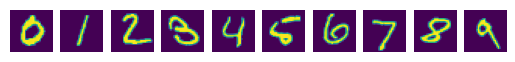

In [21]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]
targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(inversion_targets, 28, 28)

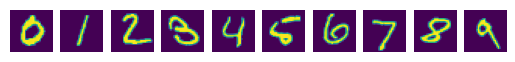

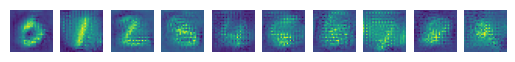

In [22]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

With noise

In [23]:
split_layer = 3

dataset = 'mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.SGD(client.parameters(), lr=0.001)
server_opt = torch.optim.SGD(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 50
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()
        noise = noisybatch(images, mean=0.0, std=sigma)
        pred = server(client(torch.add(images, noise), end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Epoch: 0 Loss: 2.3013031482696533 Acc: 11.588683351468989
Epoch: 1 Loss: 2.299302816390991 Acc: 14.967462039045554
Epoch: 2 Loss: 2.2972981929779053 Acc: 12.280701754385966
Epoch: 3 Loss: 2.2949485778808594 Acc: 13.713658804168952
Epoch: 4 Loss: 2.291714906692505 Acc: 15.452054794520548
Epoch: 5 Loss: 2.2870705127716064 Acc: 21.147540983606557
Epoch: 6 Loss: 2.2805113792419434 Acc: 25.625680087051144
Epoch: 7 Loss: 2.269629716873169 Acc: 28.726877040261154
Epoch: 8 Loss: 2.2481606006622314 Acc: 42.46053347849755
Epoch: 9 Loss: 2.200547456741333 Acc: 51.15384615384615
Epoch: 10 Loss: 2.0650076866149902 Acc: 56.1056105610561
Epoch: 11 Loss: 1.7064590454101562 Acc: 62.4390243902439
Epoch: 12 Loss: 1.267823338508606 Acc: 73.18405243036592
Epoch: 13 Loss: 0.956246018409729 Acc: 79.13234486545853
Epoch: 14 Loss: 0.8176893591880798 Acc: 83.06849315068493
Epoch: 15 Loss: 0.714192271232605 Acc: 83.42420937840785
Epoch: 16 Loss: 0.6017169952392578 Acc: 87.75623268698061
Epoch: 17 Loss: 0.5499411

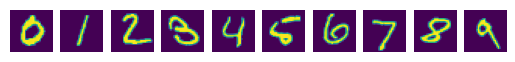

In [24]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]

noised_inversion_targets = inversion_targets
inversion_targets[0].shape

for c in range(10): 
    noise = noisybatch(inversion_targets[c], mean=0.0, std=sigma)
    noised_inversion_targets[c] = torch.add(inversion_targets[c], noise)
    
targetloader = torch.utils.data.DataLoader(noised_inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(noised_inversion_targets, 28, 28)

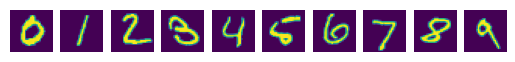

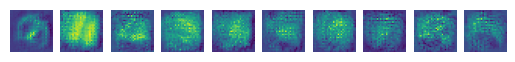

In [25]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

# Split layer = 4

 Without noise

In [4]:
split_layer = 4

dataset = 'mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.SGD(client.parameters(), lr=0.001)
server_opt = torch.optim.SGD(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 50
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Epoch: 0 Loss: 2.3034186363220215 Acc: 9.735973597359736
Epoch: 1 Loss: 2.298372983932495 Acc: 13.091309130913091
Epoch: 2 Loss: 2.2930209636688232 Acc: 14.387699066447007
Epoch: 3 Loss: 2.286285638809204 Acc: 16.11479028697572
Epoch: 4 Loss: 2.2760510444641113 Acc: 23.448654585392642
Epoch: 5 Loss: 2.2566633224487305 Acc: 35.07625272331155
Epoch: 6 Loss: 2.2110745906829834 Acc: 35.12623490669594
Epoch: 7 Loss: 2.0711209774017334 Acc: 41.88453159041394
Epoch: 8 Loss: 1.6919783353805542 Acc: 68.56039713182571
Epoch: 9 Loss: 1.0722484588623047 Acc: 77.67416346681294
Epoch: 10 Loss: 0.6943076848983765 Acc: 80.83604777415853
Epoch: 11 Loss: 0.5629660487174988 Acc: 83.67234744365035
Epoch: 12 Loss: 0.4922640919685364 Acc: 86.76872607982504
Epoch: 13 Loss: 0.4426325857639313 Acc: 88.05723720418271
Epoch: 14 Loss: 0.4045231342315674 Acc: 88.79168944778567
Epoch: 15 Loss: 0.37444692850112915 Acc: 87.93668122270742
Epoch: 16 Loss: 0.34854140877723694 Acc: 89.18623702894592
Epoch: 17 Loss: 0.326

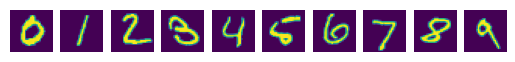

In [5]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]
targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(inversion_targets, 28, 28)

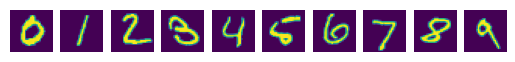

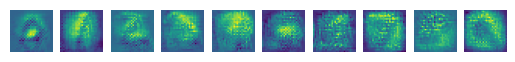

In [6]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

With noise

In [11]:
split_layer = 4

dataset = 'mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.SGD(client.parameters(), lr=0.001)
server_opt = torch.optim.SGD(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 50
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()
        noise = noisybatch(images, mean=0.0, std=sigma)
        pred = server(client(torch.add(images, noise), end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Epoch: 0 Loss: 2.3015902042388916 Acc: 16.794310722100658
Epoch: 1 Loss: 2.3003768920898438 Acc: 12.0
Epoch: 2 Loss: 2.299154281616211 Acc: 10.566448801742919
Epoch: 3 Loss: 2.2977511882781982 Acc: 10.849315068493151
Epoch: 4 Loss: 2.296095371246338 Acc: 12.037037037037036
Epoch: 5 Loss: 2.2940683364868164 Acc: 11.361141602634468
Epoch: 6 Loss: 2.2910804748535156 Acc: 14.808743169398907
Epoch: 7 Loss: 2.2868101596832275 Acc: 18.85467314964884
Epoch: 8 Loss: 2.279974937438965 Acc: 23.19868995633188
Epoch: 9 Loss: 2.2700984477996826 Acc: 30.579868708971553
Epoch: 10 Loss: 2.2510101795196533 Acc: 39.065934065934066
Epoch: 11 Loss: 2.212771415710449 Acc: 42.40750966316952
Epoch: 12 Loss: 2.112321138381958 Acc: 41.84008762322016
Epoch: 13 Loss: 1.8617315292358398 Acc: 55.83921781640413
Epoch: 14 Loss: 1.4541733264923096 Acc: 65.62328390993959
Epoch: 15 Loss: 1.092529058456421 Acc: 72.90748898678414
Epoch: 16 Loss: 0.8704341650009155 Acc: 80.0
Epoch: 17 Loss: 0.7484256029129028 Acc: 82.88238

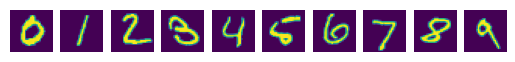

In [12]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]

noised_inversion_targets = inversion_targets
inversion_targets[0].shape

for c in range(10): 
    noise = noisybatch(inversion_targets[c], mean=0.0, std=sigma)
    noised_inversion_targets[c] = torch.add(inversion_targets[c], noise)
    
targetloader = torch.utils.data.DataLoader(noised_inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(noised_inversion_targets, 28, 28)

In [14]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

KeyboardInterrupt: 

# Split layer = 5

Without noise

In [ ]:
split_layer = 5

dataset = 'mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.SGD(client.parameters(), lr=0.001)
server_opt = torch.optim.SGD(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 50
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

In [ ]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]
targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(inversion_targets, 28, 28)

In [ ]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

With noise

In [ ]:
split_layer = 5

dataset = 'mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.SGD(client.parameters(), lr=0.001)
server_opt = torch.optim.SGD(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 50
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()
        noise = noisybatch(images, mean=0.0, std=sigma)
        pred = server(client(torch.add(images, noise), end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

In [ ]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]

noised_inversion_targets = inversion_targets
inversion_targets[0].shape

for c in range(10): 
    noise = noisybatch(inversion_targets[c], mean=0.0, std=sigma)
    noised_inversion_targets[c] = torch.add(inversion_targets[c], noise)
    
targetloader = torch.utils.data.DataLoader(noised_inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(noised_inversion_targets, 28, 28)

In [ ]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

# Split layer = 6

Without noise

In [ ]:
split_layer = 6

dataset = 'mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.SGD(client.parameters(), lr=0.001)
server_opt = torch.optim.SGD(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 50
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

In [ ]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]
targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(inversion_targets, 28, 28)

In [ ]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

With noise

In [ ]:
split_layer = 6

dataset = 'mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)
        
client_opt = torch.optim.SGD(client.parameters(), lr=0.001)
server_opt = torch.optim.SGD(server.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 50
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()
        noise = noisybatch(images, mean=0.0, std=sigma)
        pred = server(client(torch.add(images, noise), end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

In [ ]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]

noised_inversion_targets = inversion_targets
inversion_targets[0].shape

for c in range(10): 
    noise = noisybatch(inversion_targets[c], mean=0.0, std=sigma)
    noised_inversion_targets[c] = torch.add(inversion_targets[c], noise)
    
targetloader = torch.utils.data.DataLoader(noised_inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(noised_inversion_targets, 28, 28)

In [ ]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)